In [1]:
import os, tarfile
import pandas as pd
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master"
HOUSING_PATH  = "datasets/housing"
HOUSING_URL   = '/'.join([DOWNLOAD_ROOT, HOUSING_PATH, "housing.tgz"])

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # Create Dataset Folder
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    # Create file to store download
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    # Download into the file specified
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # Extract the file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    
    if not os.path.isfile(csv_path) :
        fetch_housing_data()
    
    return pd.read_csv(csv_path)

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np 

def split_housing_data(housing=None):
    
    if housing is None:
        housing = load_housing_data()
    
    housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
    housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis = 1, inplace=True)

    return (strat_train_set, strat_test_set)

In [3]:
train, test = split_housing_data(load_housing_data())
housing = train.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


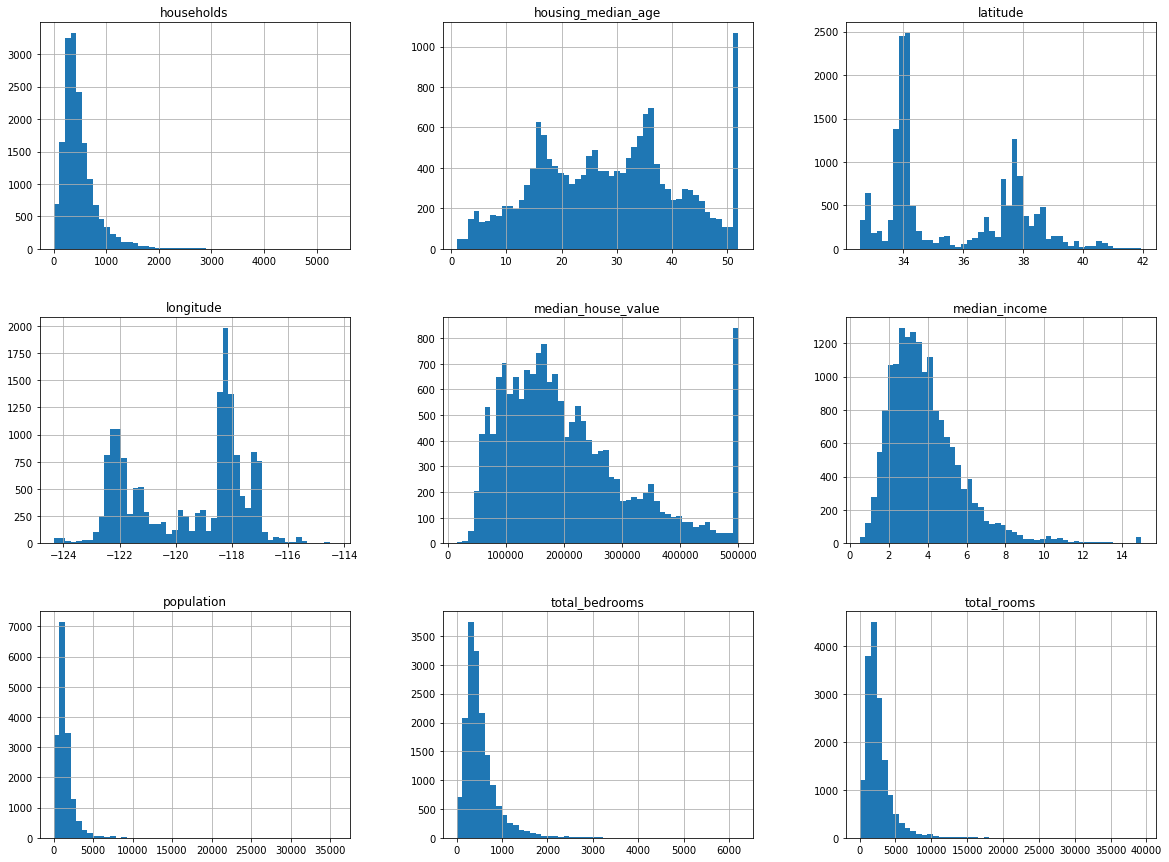

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20, 15))
plt.show()

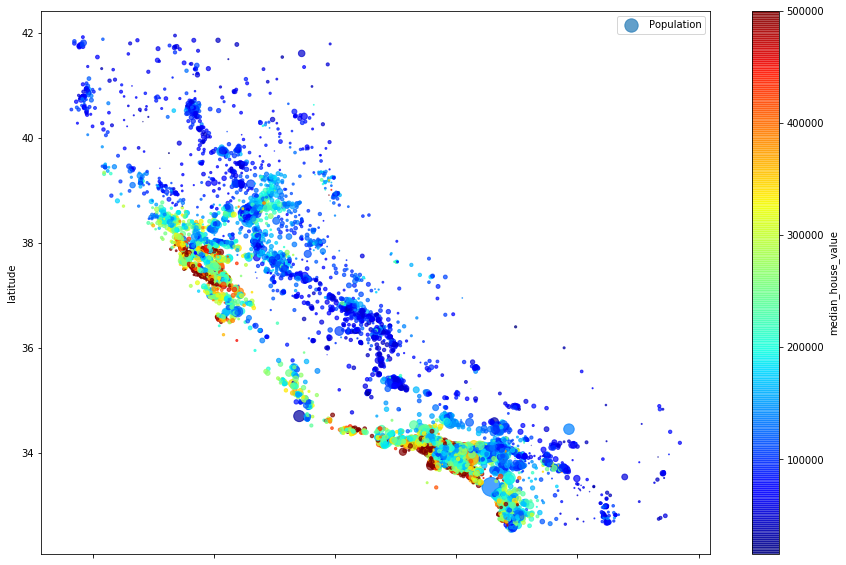

In [11]:
housing.plot(
    kind = 'scatter', x='longitude', y = 'latitude',
    c = 'median_house_value', s = housing['population'] / 100, 
    cmap = plt.get_cmap('jet'), alpha = 0.7, colorbar = True,
    label = 'Population', figsize = (15, 10)
)
plt.show()

In [13]:
# Display correlations
housing.corr()["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X [ : , rooms_ix ] / X [ : , household_ix ]
        population_per_household = X [ : , population_ix ] / X [ : , household_ix ]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X [ : , bedrooms_ix ] / X [ : , rooms_ix ]
            return np.c_[ X, rooms_per_household, population_per_household, bedrooms_per_room ]
        else:
            return np.c_[ X, rooms_per_household, population_per_household ]

attribute_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attribute_adder.transform(housing.values)


In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [28]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

train, test = split_housing_data(load_housing_data())

housing = train.drop("median_house_value", axis = 1)
housing_labels = train["median_house_value"]

housing_numeric = housing.drop("ocean_proximity", axis = 1)

numeric_attributes = list(housing_numeric)
categorical_attributes = ["ocean_proximity"]

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_attributes)),
    ('imputer', SimpleImputer()),
    ('attribute_adder', CombinedAttributesAdder()),
    ('scaler', StandardScaler())
])


categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributes)),
    ('onehot_encoder', OneHotEncoder())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])


housing_prepared = full_pipeline.fit_transform(housing)

In [29]:
housing_prepared.toarray()

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [30]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(housing_prepared, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

some_predictions = linear_regressor.predict(some_data_prepared)
some_predictions

array([210944.00383406, 318525.57375899, 210996.32847271,  60049.49158389,
       191123.83670806])

In [35]:
np.array(some_labels)

array([286600., 340600., 196900.,  46300., 254500.])

In [36]:
from sklearn.metrics import mean_squared_error
housing_predictions = linear_regressor.predict(housing_prepared)
linreg_mse = mean_squared_error(housing_labels, housing_predictions)
linreg_rmse= np.sqrt(linreg_mse)
linreg_rmse

68727.6207005888

In [38]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor = DecisionTreeRegressor()
decision_tree_regressor.fit(housing_prepared, housing_labels)

some_predictions = decision_tree_regressor.predict(some_data_prepared)
dectree_mse = mean_squared_error(some_predictions, some_labels)
dectree_rmse = np.sqrt(dectree_mse)
dectree_rmse

0.0

In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    decision_tree_regressor, 
    housing_prepared, housing_labels, 
    scoring="neg_mean_squared_error", 
    cv = 10)

tree_rmse_scores = np.sqrt(-scores)

In [41]:
tree_rmse_scores

array([69838.97743934, 66737.0524795 , 70881.25161879, 69006.32457635,
       70315.1664059 , 73697.00014058, 71534.53897373, 70691.68187052,
       75889.2482131 , 69327.26635146])

In [47]:
def describe(scores):
    mean = scores.mean()
    stddev = scores.std()
    print("Scores : ", scores)
    print("Mean : ", mean)
    print("Standard Deviation : ", stddev)
describe(tree_rmse_scores)

Scores :  [69838.97743934 66737.0524795  70881.25161879 69006.32457635
 70315.1664059  73697.00014058 71534.53897373 70691.68187052
 75889.2482131  69327.26635146]
Mean :  70791.85080692905
Standard Deviation :  2406.29719065435


In [49]:
scores = cross_val_score(
    linear_regressor,
    housing_prepared, housing_labels,
    scoring='neg_mean_squared_error',
    cv = 10
)

lin_reg_scores = np.sqrt(-scores)

In [50]:
describe(lin_reg_scores)

Scores :  [66991.93073767 67048.67920753 70444.05575277 74774.02214506
 68102.64264297 71319.00741855 65085.09678642 68353.36278416
 71773.08100879 67789.05274345]
Mean :  69168.09312273604
Standard Deviation :  2721.508677198044


In [52]:
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor()

forest_regressor.fit(housing_prepared, housing_labels)
some_predictions = forest_regressor.predict(some_data_prepared)
some_predictions, some_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(array([262670., 333510., 214540.,  51670., 241840.]), 17606    286600.0
 18632    340600.0
 14650    196900.0
 3230      46300.0
 3555     254500.0
 Name: median_house_value, dtype: float64)

In [53]:
scores = cross_val_score(
    forest_regressor,
    housing_prepared, housing_labels,
    scoring='neg_mean_squared_error',
    cv = 10
)

forest_scores = np.sqrt(-scores)
describe(forest_scores)

Scores :  [51978.55032937 50315.63939044 53124.99176818 54198.83096729
 53175.7890925  56045.70787554 51102.54434828 51074.10203151
 55125.51800149 53144.95692629]
Mean :  52928.66307308851
Standard Deviation :  1755.1803001195356


In [54]:
housing_predicted = forest_regressor.predict(housing_prepared)
mse = mean_squared_error(housing_predicted, housing_labels)
rmse = np.sqrt(mse)
rmse

22193.535900974093

In [55]:
# Saving model.

from sklearn.externals import joblib

joblib.dump(forest_regressor, 'forest_regressor_housing.pkl')


['forest_regressor_housing.pkl']